In [130]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
import eleanor
from astropy.convolution import convolve, Box1DKernel

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [10]:
#wd 1504+546 - see if I can find the ecclipse with lightcurve bls
coords = (226.5226, 54.4718)
star = eleanor.Source(sector=16, coords = coords)
#star = eleanor.multi_sectors('all', coords = coords)

No eleanor postcard has been made for your target (yet). Using TessCut instead.


In [11]:
star

In [12]:
data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf=True, do_pca=True)

Set MJD-OBS to 58738.143215 from DATE-OBS.
Set MJD-END to 58762.809625 from DATE-END'. [astropy.wcs.wcs]
/home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint

/home/david/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/david/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/david/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/david/anaconda3/lib/python3.7/site-packages/tensorboard/co

(0.0, 2.0)

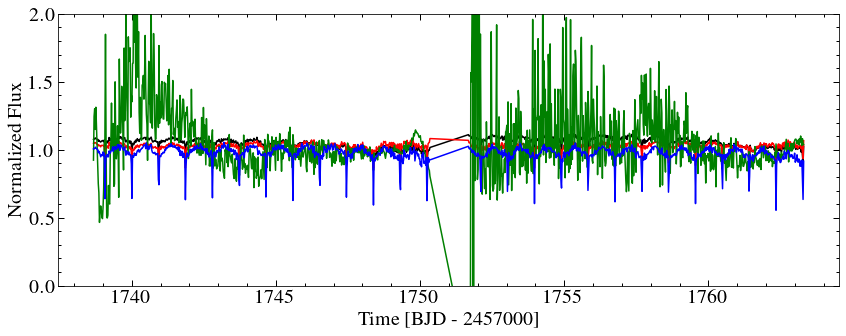

In [14]:
q = data.quality == 0

plt.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q])+0.06, 'k')
plt.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) + 0.03, 'r')
plt.plot(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q]), 'g')
plt.plot(data.time[q], data.psf_flux[q]/np.nanmedian(data.psf_flux[q]) - 0.02, 'b')
plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')
plt.ylim(0, 2)

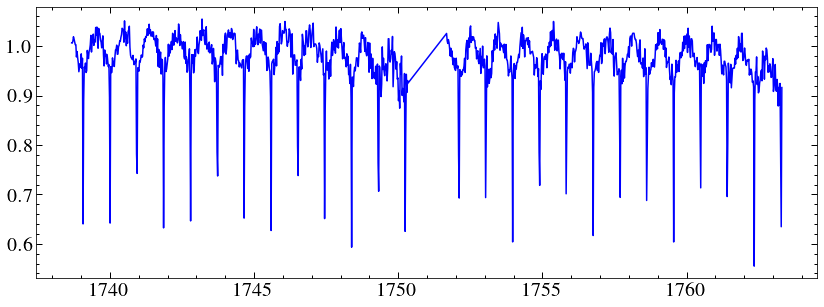

In [15]:
plt.plot(data.time[q], data.psf_flux[q]/np.nanmedian(data.psf_flux[q]) - 0.02, 'b')

Looks good!

In [16]:
data.save(directory='eleanor_files/')

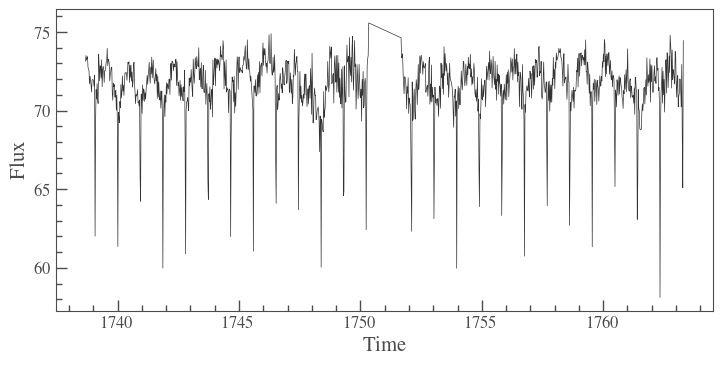

In [17]:
data = fits.getdata('eleanor_files/hlsp_eleanor_tess_ffi_tic137841673_s16_tess_v1.0.0_lc.fits')
q = (data['QUALITY'] == 0)
lc = lk.LightCurve(time = data['Time'][q], flux= data['CORR_FLUX'][q], flux_err = data['FLUX_ERR'][q])

#lc = data.to_lightkurve()
lc.plot()

In [20]:
#known period
pa =0.93072*u.d
print(pa.to(u.hour))

22.33728 h


/home/david/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


0.9305579735105668 d


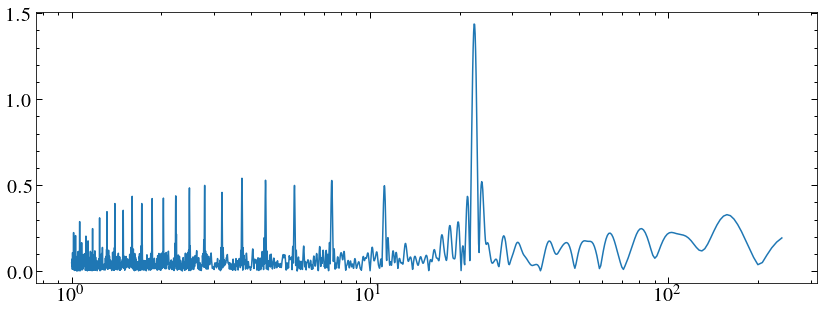

In [23]:
pg = lc.to_periodogram(oversample_factor=10,minimum_period=60*u.minute, maximum_period=10*u.day)
plt.plot(pg.period.to(u.hour), pg.power)
plt.xscale('log')
print(pg.period_at_max_power)

In [52]:
fitter = fitting.LevMarLSQFitter()

0.9347423979395052 d
360.0 min
Model: Lorentz1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             x_0                 fwhm        
                               d                   d          
    ------------------ ------------------ --------------------
    0.9353681309705568 0.9317836596022608 0.017623165965151327


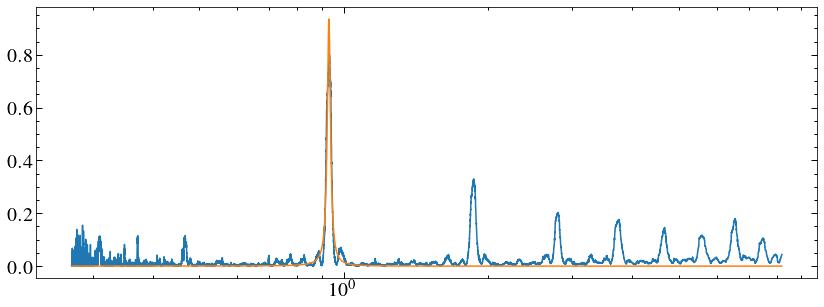

In [59]:
pgb = lc.to_periodogram(method = 'bls', frequency_factor=0.11)#,minimum_period=60*u.minute, maximum_period=10*u.day)
plt.plot(pgb.period, pgb.power)
plt.xscale('log')
print(pgb.period_at_max_power)
print(pgb.duration_at_max_power.to(u.min))


l_init =  models.Lorentz1D(0.8,pgb.period_at_max_power , fwhm=0.01)#+models.Const1D(0)
mask = (pgb.period.value > 0.8) & (pgb.period.value < 1.1)
l_fit=fitter(l_init, pgb.period[mask], pgb.power[mask], maxiter=1000000)

plt.plot(pgb.period, l_fit(pgb.period))
print(l_fit)

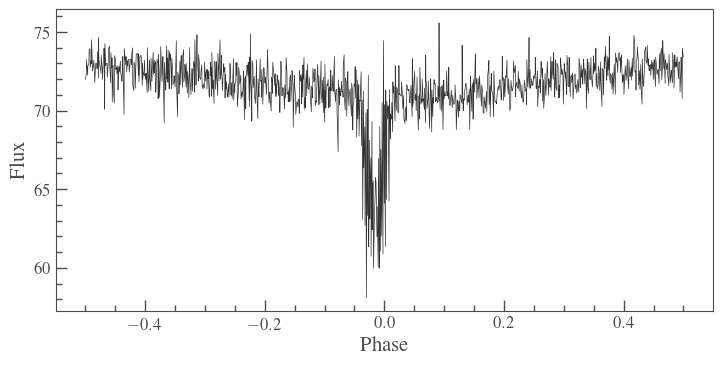

In [157]:
lcf = lc.fold(l_fit.x_0, t0=pgb.transit_time_at_max_power)#-0.5*l_fit.x_0.value)
lcf.plot()

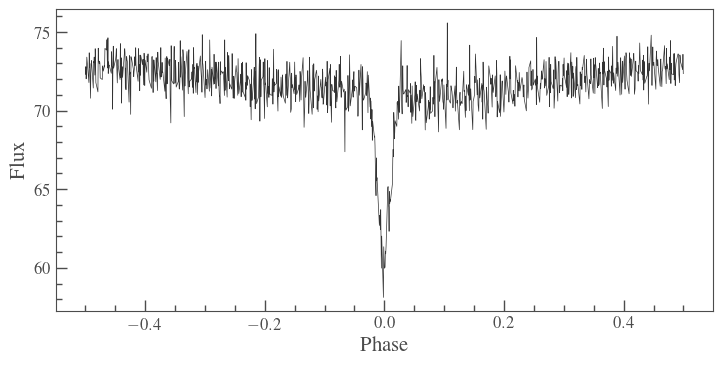

In [158]:
lcf = lc.fold(pa, t0=pgb.transit_time_at_max_power)
lcf.plot()

What if I remove the modulation first- or fit to it as the period?

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=1.44067622, frequency=1.07158095, phase=0.20436109)>

    [1]: <Const1D(amplitude=71.60752058)>
Parameters:
       amplitude_0        frequency_0          phase_0          amplitude_1   
    ------------------ ----------------- ------------------- -----------------
    1.4406762193731013 1.071580946401834 0.20436109008543837 71.60752058366953
0.9332006166755864


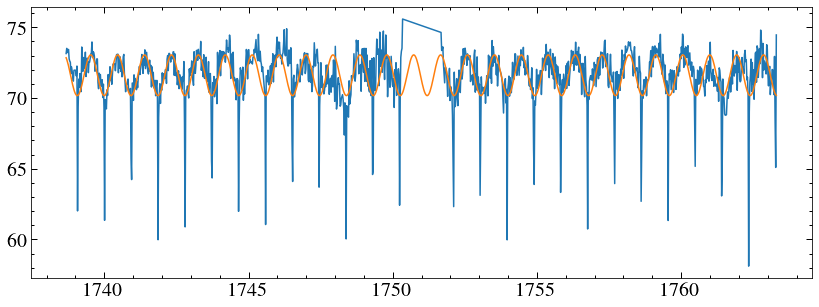

In [177]:
plt.plot(lc.time, lc.flux)
sin_mod =  models.Sine1D(0.01,1/pg.period_at_max_power.value)+models.Const1D(np.median(lc.flux))#+models.Sine1D(0.01,2/pg.period_at_max_power.value)
sin_fit = fitter(sin_mod, lc.time, lc.flux, weights = 1/lc.flux_err, maxiter=100000)
timefit = np.linspace(lc.time[0], lc.time[-1], 1000)
plt.plot(timefit, sin_fit(timefit))
print(sin_fit)
print(1/sin_fit.frequency_0)
#print(1/sin_fit.frequency_2)

2.000852903474621

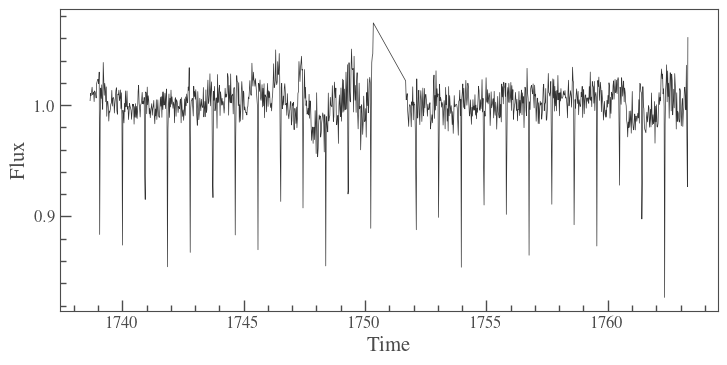

In [76]:
lc1 = lc / sin_fit(lc.time)
lc1.plot()

`period` contains 173183 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


0.9307048499085682 d
60.0 min


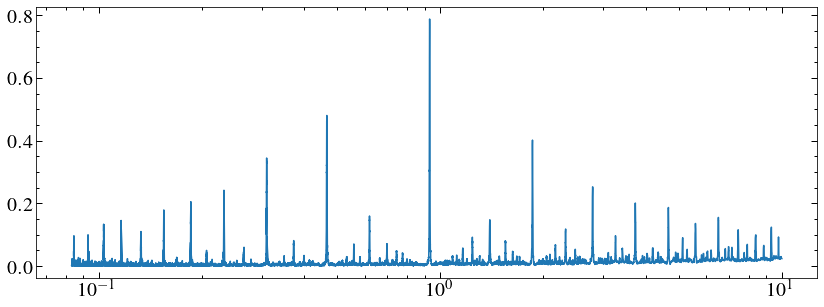

In [100]:
pgb1 = lc1.to_periodogram(method = 'bls', frequency_factor=1,minimum_period=1/12, duration=1/24, maximum_period=10)
plt.plot(pgb1.period, pgb1.power)
plt.xscale('log')
print(pgb1.period_at_max_power)
print(pgb1.duration_at_max_power.to(u.min))


#l_init1 =  models.Lorentz1D(0.01,pgb1.period_at_max_power , fwhm=0.01)#+models.Const1D(0)
#mask = (pgb1.period.value > 0.8) & (pgb1.period.value < 1.1)
#l_fit1=fitter(l_init1, pgb1.period[mask], pgb1.power[mask], maxiter=1000000)

#plt.plot(pgb1.period, l_fit1(pgb1.period))
#print(l_fit1)

0.9307048499085682 d
60.0 min
Model: Lorentz1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             x_0                 fwhm        
                               d                   d          
    ------------------ ----------------- ---------------------
    0.9146181719574128 0.930678356225613 0.0028366163448544117


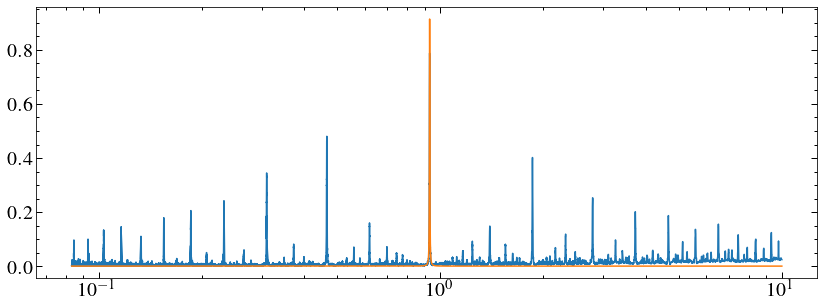

In [101]:
plt.plot(pgb1.period, pgb1.power)
plt.xscale('log')
print(pgb1.period_at_max_power)
print(pgb1.duration_at_max_power.to(u.min))


l_init1 =  models.Lorentz1D(0.01,pgb1.period_at_max_power , fwhm=0.01)#+models.Const1D(0)
mask = (pgb1.period.value > 0.8) & (pgb1.period.value < 1.1)
l_fit1=fitter(l_init1, pgb1.period[mask], pgb1.power[mask], maxiter=1000000)

plt.plot(pgb1.period, l_fit1(pgb1.period))
print(l_fit1)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Sine1D(amplitude=0.89997309, frequency=1., phase=-2.2801258)>

    [1]: <Const1D(amplitude=71.87737894)>

    [2]: <Gaussian1D(amplitude=-10.38094562, mean=-0.00034419, stddev=0.010138)>
Parameters:
       amplitude_0     frequency_0 ...         mean_2               stddev_2      
    ------------------ ----------- ... ---------------------- --------------------
    0.8999730941074833         1.0 ... -0.0003441851463897525 0.010137996076578906


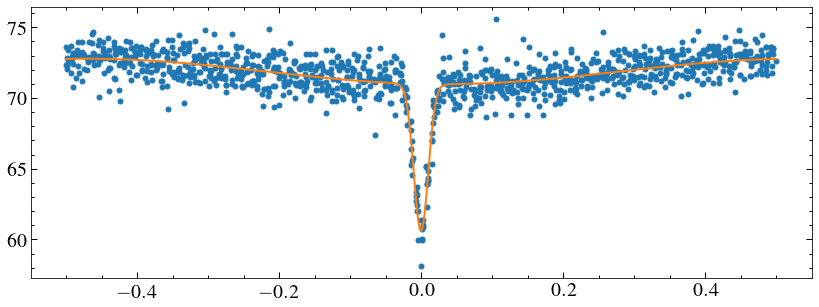

In [127]:
lcf = lc.fold(l_fit1.x_0, t0=pgb1.transit_time_at_max_power)
#plt.plot(lcf.time, lcf.flux)
#plt.errorbar(lcf.time, lcf.flux, yerr=lcf.flux_err, marker='o', ls='none')
plt.errorbar(lcf.time, lcf.flux, marker='o', ls='none', zorder=-1, ms=5)

model_init = models.Sine1D(amplitude=0.4, frequency=1, fixed=(dict(frequency=True)))+models.Const1D(np.median(lc.flux))+models.Gaussian1D(-10, 0, 0.05)
#+ models.Box1D(amplitude=-10, x_0=0, width=0.04)
model_fit = fitter(model_init, lcf.time, lcf.flux, weights = 1/lcf.flux_err, maxiter=100000)
timefit = np.linspace(lcf.time[0], lcf.time[-1], 1000)
plt.plot(timefit, model_fit(timefit), lw=2)
print(model_fit)

Not bad, given that the transit duration is ~ the cadence!

In [104]:
print(l_fit1.x_0)
print(pa)

Parameter('x_0', value=0.930678356225613, unit=d)
0.93072 d


What does the hst spectrum look like?

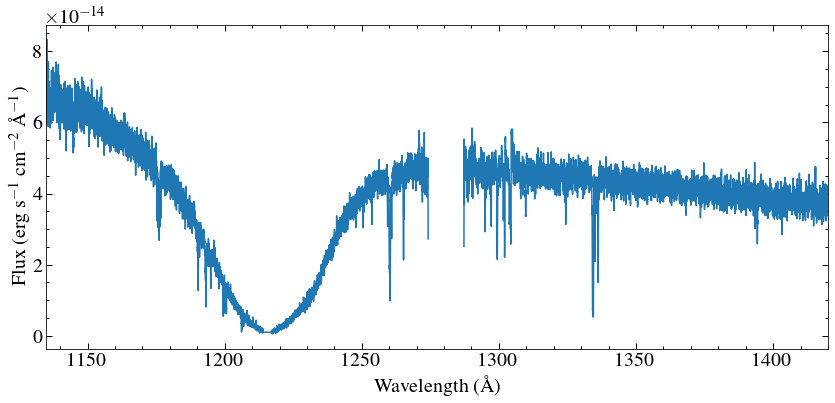

In [150]:
plt.figure(figsize=(12, 6))
dpath = '/media/david/5tb_storage1/pceb_data/ldlc11010_x1dsum.fits'
data = fits.getdata(dpath, 1)
smooth = 5
for dt in data:

    w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
    mask = (f>0) & (dq == 0) & (w < 1214) | (w > 1217) & (f>0) & (dq == 0) 
    w, f, e = w[mask], f[mask], e[mask]
    f = convolve(f,Box1DKernel(smooth))
    e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
    plt.plot(w,f, c='C0')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.xlim(1135, 1420)
plt.tight_layout()

(1740.0, 1750.0)

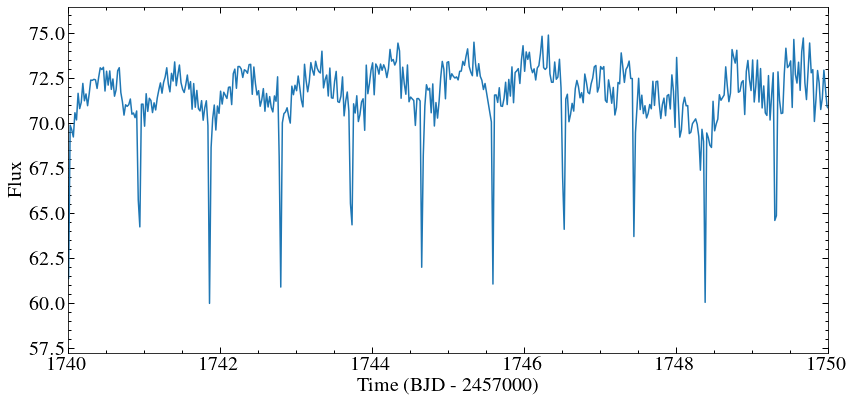

In [155]:
plt.figure(figsize=(12, 6))
plt.plot(lc.time, lc.flux)
plt.ylabel('Flux ')
plt.xlabel('Time (BJD - 2457000)')
plt.tight_layout()
#plt.xlim(lc.time[0], lc.time[-1])
plt.xlim(1740, 1750)

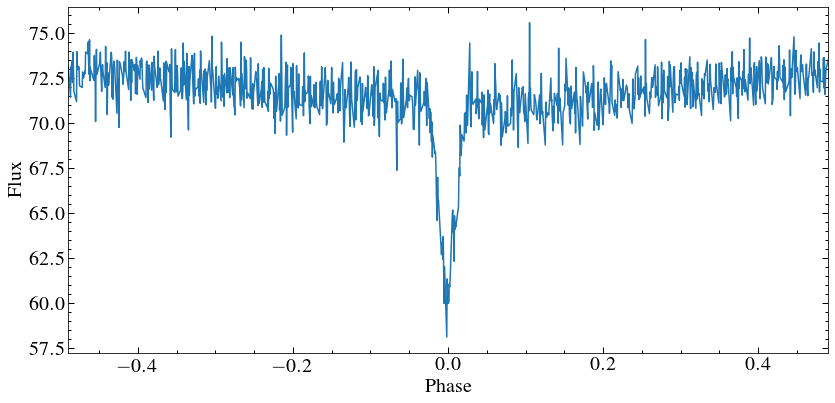

In [164]:
plt.figure(figsize=(12, 6))
plt.plot(lcf.time, lcf.flux)
plt.ylabel('Flux ')
plt.xlabel('Phase')
plt.xlim(-0.49, 0.49)
plt.tight_layout()

#plt.xlim(lc.time[0], lc.time[-1])
#plt.xlim(1740, 1750)


Can we see ellipsodal modulation?

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=0.96312954, frequency=1.07165693, phase=-1.93809977)>

    [1]: <Const1D(amplitude=71.8492432)>
Parameters:
       amplitude_0       frequency_0          phase_0          amplitude_1   
    ------------------ ---------------- ------------------- -----------------
    0.9631295421382076 1.07165692616577 -1.9380997695281377 71.84924320424861
0.9331344533719873


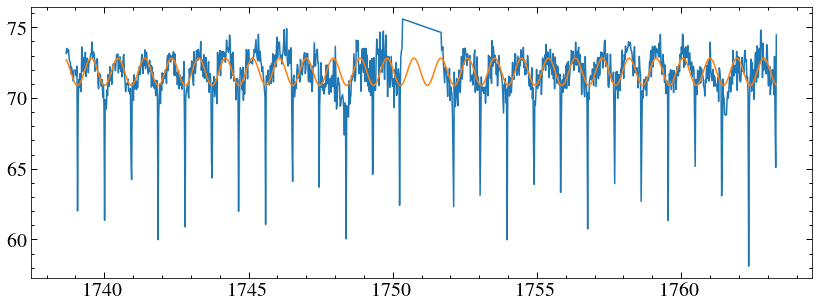

In [200]:
plt.plot(lc.time, lc.flux)
sin_mod =  models.Sine1D(2,1/pg.period_at_max_power.value)+models.Const1D(np.median(lc.flux))#+models.Sine1D(1,2/pg.period_at_max_power.value)
mask = (lc.flux > 68)
sin_fit = fitter(sin_mod, lc.time[mask], lc.flux[mask], weights = 1/lc.flux_err[mask], maxiter=100000)
timefit = np.linspace(lc.time[0], lc.time[-1], 1000)
plt.plot(timefit, sin_fit(timefit))
print(sin_fit)
print(1/sin_fit.frequency_0)
#print(1/sin_fit.frequency_2)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=0.08490431, frequency=2.14090559, phase=-1.56351965)>

    [1]: <Const1D(amplitude=71.83589951)>
Parameters:
        amplitude_0        frequency_0           phase_0          amplitude_1   
    ------------------- ------------------ ------------------- -----------------
    0.08490431037114773 2.1409055947750826 -1.5635196479407836 71.83589951313068
0.4670920578845314
Parameter('phase', value=-1.9380997695281377)
Parameter('phase', value=-1.5635196479407836)


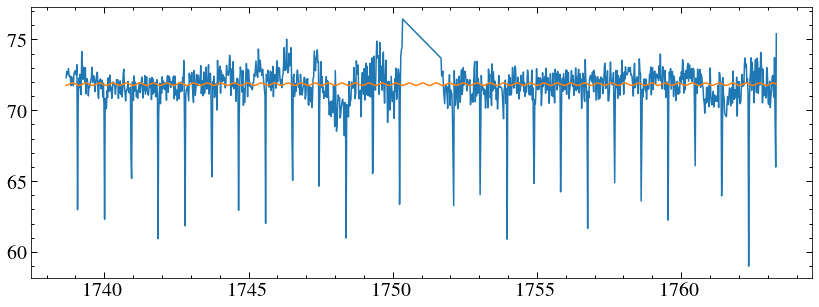

In [203]:
lc1 = lc - sin_fit[0](lc.time)
plt.plot(lc1.time, lc1.flux)
sin_mod1 =  models.Sine1D(1,2/pg.period_at_max_power.value, phase=sin_fit.phase_0+0.5)+models.Const1D(np.median(lc1.flux))
mask = (lc1.flux > 68)
sin_fit1 = fitter(sin_mod1, lc1.time[mask], lc1.flux[mask], weights = 1/lc1.flux_err[mask], maxiter=100000)
plt.plot(timefit, sin_fit1(timefit))
print(sin_fit1)
print(1/sin_fit1.frequency_0)
print(sin_fit.phase_0)
print(sin_fit1.phase_0)

No real evidence, could be on EG Uma.